In [6]:
from platform import python_version

print(python_version())

3.7.4


In [7]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
All Unmodified Gers list size: 1273586
whiskers:  [0.0, 291.0]
caps:  [0.0, 291.0]
boxes:  [16.0]
medians:  [43.0]
means:  [1815.342362431748]
fliers:  []


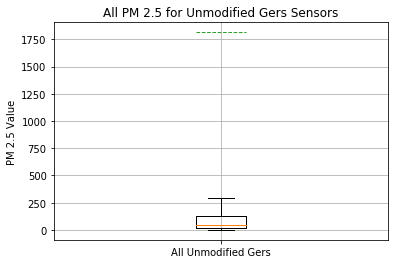

In [14]:
# all_unmodified_gers_sensors - This is the working boxplot for all_unmodified_gers_sensors Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['All Unmodified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('All PM 2.5 for Unmodified Gers Sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
unmodified_gers = ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

all_unmodified_gers_sensors = [data['pm2_5']]
print('{} list size: {}'.format(labels[0], len(data['pm2_5'])))
results = plt.boxplot(all_unmodified_gers_sensors, showfliers=False, labels=labels, showmeans=True, meanline=True)

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
Mon list size: 174434
Tue list size: 177116
Wed list size: 178763
Thu list size: 190824
Fri list size: 187028
Sat list size: 184939
Sun list size: 180482
total for all days: 1273586

whiskers:  [0.0, 291.0, 0.0, 310.0, 0.0, 267.0, 0.0, 275.0, 0.0, 287.0, 0.0, 277.0, 0.0, 320.0]
caps:  [0.0, 291.0, 0.0, 310.0, 0.0, 267.0, 0.0, 275.0, 0.0, 287.0, 0.0, 277.0, 0.0, 320.0]
boxes:  [16.0, 15.0, 12.0, 15.0, 17.0, 17.0, 18.0]
medians:  [45.0, 43.0, 34.0, 40.0, 44.0, 44.0, 52.0]
means:  [134.60899824575483, 126.30096659816165, 121.84421272858478, 116.23330398691988, 134.09690527621532, 129.2837313925132, 12041.053894571203]
fliers:  []


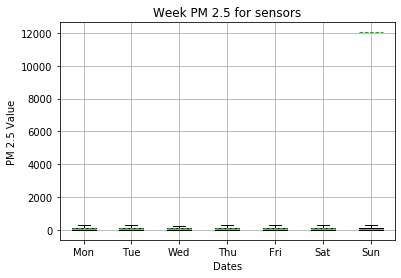

In [15]:
# Day - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
unmodified_gers = ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')]['pm2_5']
tuesday = data[data.index.day_name() == 'Tuesday']['pm2_5']
wednesday = data[data.index.day_name() == 'Wednesday']['pm2_5']
thursday = data[data.index.day_name() == 'Thursday']['pm2_5']
friday = data[data.index.day_name() == 'Friday']['pm2_5']
saturday = data[data.index.day_name() == 'Saturday']['pm2_5']
sunday = data[data.index.day_name() == 'Sunday']['pm2_5']
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)

i = 0
cumulative = 0
for day in all_days:
    print('{} list size: {}'.format(labels[i], len(day)))
    cumulative += len(day)
    i+= 1
print('total for all days: {}'.format(cumulative))
print()

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
Monday - NJ list size: 2817
Monday - NS list size: 10136
Monday - NU list size: 12510
Monday - OK list size: 14065
Monday - OR list size: 3345
Monday - PA list size: 19928
Monday - RI list size: 11780
Monday - SD list size: 21369
Monday - UT list size: 18165
Monday - VA list size: 30104
Monday - WI list size: 30215
Monday total: 174434

whiskers:  [1.0, 85.0, 0.0, 676.0, 4.0, 240.0, 1.0, 174.0, 7.0, 328.0, 2.0, 473.0, 1.0, 1219.0, 1.0, 215.0, 1.0, 160.0, 0.0, 162.0, 2.0, 214.0]
caps:  [1.0, 85.0, 0.0, 676.0, 4.0, 240.0, 1.0, 174.0, 7.0, 328.0, 2.0, 473.0, 1.0, 1219.0, 1.0, 215.0, 1.0, 160.0, 0.0, 162.0, 2.0, 214.0]
boxes:  [10.0, 25.0, 30.0, 14.0, 34.0, 21.0, 52.0, 20.0, 8.0,

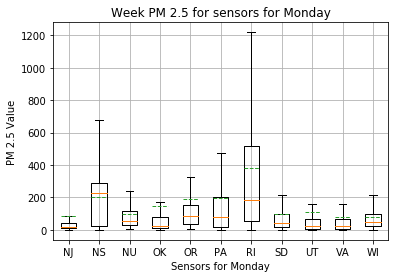

Tuesday - NJ list size: 2641
Tuesday - NS list size: 10242
Tuesday - NU list size: 11852
Tuesday - OK list size: 13281
Tuesday - OR list size: 3751
Tuesday - PA list size: 19272
Tuesday - RI list size: 14396
Tuesday - SD list size: 22830
Tuesday - UT list size: 17809
Tuesday - VA list size: 30341
Tuesday - WI list size: 30701
Tuesday total: 177116

whiskers:  [1.0, 94.0, 0.0, 744.0, 1.0, 186.0, 0.0, 150.0, 4.0, 160.0, 1.0, 449.0, 0.0, 1043.0, 0.0, 267.0, 0.0, 149.0, 0.0, 199.0, 0.0, 264.0]
caps:  [1.0, 94.0, 0.0, 744.0, 1.0, 186.0, 0.0, 150.0, 4.0, 160.0, 1.0, 449.0, 0.0, 1043.0, 0.0, 267.0, 0.0, 149.0, 0.0, 199.0, 0.0, 264.0]
boxes:  [9.0, 18.25, 16.0, 10.0, 13.0, 27.0, 38.0, 22.0, 9.0, 7.0, 24.0]
medians:  [18.0, 159.0, 38.0, 22.0, 30.0, 90.0, 165.0, 48.0, 27.0, 25.0, 50.0]
means:  [109.22680802726241, 203.23481741847294, 81.65035437057037, 103.35953617950456, 121.33591042388696, 147.88122665006227, 294.45450125034733, 104.24213753832676, 140.90426189005558, 81.63603704558189, 89.550

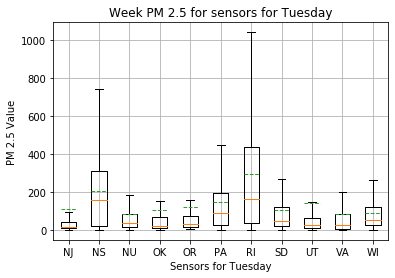

Wednesday - NJ list size: 2609
Wednesday - NS list size: 9565
Wednesday - NU list size: 12129
Wednesday - OK list size: 15381
Wednesday - OR list size: 3116
Wednesday - PA list size: 20099
Wednesday - RI list size: 14519
Wednesday - SD list size: 20822
Wednesday - UT list size: 17417
Wednesday - VA list size: 31373
Wednesday - WI list size: 31733
Wednesday total: 178763

whiskers:  [1.0, 81.0, 0.0, 673.0, 0.0, 182.0, 0.0, 116.0, 1.0, 68.0, 0.0, 334.0, 0.0, 1064.0, 0.0, 278.0, 0.0, 118.0, 0.0, 169.0, 1.0, 247.0]
caps:  [1.0, 81.0, 0.0, 673.0, 0.0, 182.0, 0.0, 116.0, 1.0, 68.0, 0.0, 334.0, 0.0, 1064.0, 0.0, 278.0, 0.0, 118.0, 0.0, 169.0, 1.0, 247.0]
boxes:  [11.0, 19.0, 15.0, 6.0, 8.0, 17.0, 27.0, 21.0, 6.0, 7.0, 15.0]
medians:  [22.0, 60.0, 33.0, 17.0, 26.0, 51.0, 173.0, 47.0, 19.0, 23.0, 39.0]
means:  [71.94059026446915, 163.09472033455305, 81.07923159370105, 92.08718548858982, 42.70442875481386, 143.97989949748742, 289.9559198291893, 153.9844395351071, 95.08933800310042, 94.5073789564

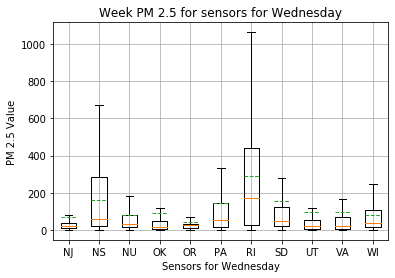

Thursday - NJ list size: 2798
Thursday - NS list size: 11118
Thursday - NU list size: 13113
Thursday - OK list size: 17180
Thursday - OR list size: 3132
Thursday - PA list size: 20562
Thursday - RI list size: 15609
Thursday - SD list size: 23800
Thursday - UT list size: 18759
Thursday - VA list size: 31681
Thursday - WI list size: 33072
Thursday total: 190824

whiskers:  [2.0, 88.0, 0.0, 664.0, 2.0, 195.0, 0.0, 144.0, 3.0, 78.0, 0.0, 339.0, 1.0, 1002.0, 0.0, 260.0, 1.0, 144.0, 0.0, 209.0, 1.0, 234.0]
caps:  [2.0, 88.0, 0.0, 664.0, 2.0, 195.0, 0.0, 144.0, 3.0, 78.0, 0.0, 339.0, 1.0, 1002.0, 0.0, 260.0, 1.0, 144.0, 0.0, 209.0, 1.0, 234.0]
boxes:  [8.0, 20.25, 20.0, 7.0, 13.0, 24.0, 33.0, 20.0, 9.0, 7.0, 22.0]
medians:  [18.0, 58.5, 41.0, 20.0, 24.0, 55.0, 154.0, 58.0, 22.0, 26.0, 51.0]
means:  [51.2398141529664, 159.60028782155064, 96.78921680774803, 102.69359720605355, 53.13952745849298, 119.60830658496255, 289.55769107566147, 121.51298319327731, 74.93112639266485, 94.4485022568732, 84.

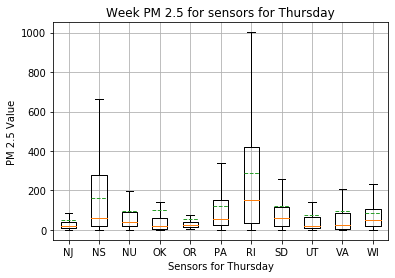

Friday - NJ list size: 3621
Friday - NS list size: 8165
Friday - NU list size: 12671
Friday - OK list size: 17822
Friday - OR list size: 2739
Friday - PA list size: 20115
Friday - RI list size: 12671
Friday - SD list size: 25426
Friday - UT list size: 18153
Friday - VA list size: 32532
Friday - WI list size: 33113
Friday total: 187028

whiskers:  [2.0, 165.0, 0.0, 765.0, 2.0, 219.0, 1.0, 166.0, 4.0, 283.0, 1.0, 377.0, 1.0, 1098.0, 2.0, 263.0, 0.0, 110.0, 0.0, 190.0, 1.0, 269.0]
caps:  [2.0, 165.0, 0.0, 765.0, 2.0, 219.0, 1.0, 166.0, 4.0, 283.0, 1.0, 377.0, 1.0, 1098.0, 2.0, 263.0, 0.0, 110.0, 0.0, 190.0, 1.0, 269.0]
boxes:  [13.0, 35.0, 22.0, 11.0, 13.0, 30.0, 42.0, 23.0, 13.0, 8.0, 24.0]
medians:  [26.0, 243.0, 41.0, 26.0, 33.0, 67.0, 159.0, 57.0, 26.0, 25.0, 58.0]
means:  [218.1748135874068, 210.94378444580528, 118.97979638544709, 123.31831444282348, 242.69295363271266, 136.19915485955755, 313.66813984689446, 156.01423739479273, 70.5811711562827, 85.29850608631502, 104.49844471959653

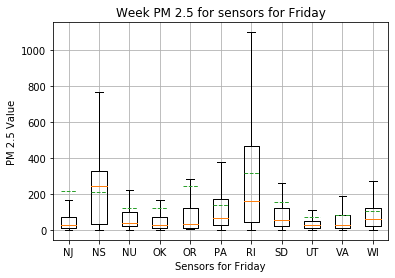

Saturday - NJ list size: 3609
Saturday - NS list size: 7465
Saturday - NU list size: 13877
Saturday - OK list size: 18306
Saturday - OR list size: 2657
Saturday - PA list size: 19946
Saturday - RI list size: 12305
Saturday - SD list size: 23269
Saturday - UT list size: 17584
Saturday - VA list size: 32813
Saturday - WI list size: 33108
Saturday total: 184939

whiskers:  [2.0, 94.0, 5.0, 708.0, 3.0, 218.0, 1.0, 223.0, 14.0, 255.0, 0.0, 417.0, 2.0, 1273.0, 1.0, 212.0, 0.0, 178.0, 0.0, 171.0, 1.0, 199.0]
caps:  [2.0, 94.0, 5.0, 708.0, 3.0, 218.0, 1.0, 223.0, 14.0, 255.0, 0.0, 417.0, 2.0, 1273.0, 1.0, 212.0, 0.0, 178.0, 0.0, 171.0, 1.0, 199.0]
boxes:  [9.0, 32.0, 21.0, 13.0, 41.0, 30.0, 58.0, 20.0, 13.0, 6.0, 24.0]
medians:  [17.0, 200.0, 42.0, 29.0, 67.0, 77.0, 255.0, 46.0, 32.0, 24.0, 49.0]
means:  [82.67608755888058, 194.22692565304754, 89.56337825178353, 173.47432535780618, 118.93225442228076, 134.37145292289182, 375.8238927265339, 80.90377755812455, 155.31693585077343, 88.314783774723

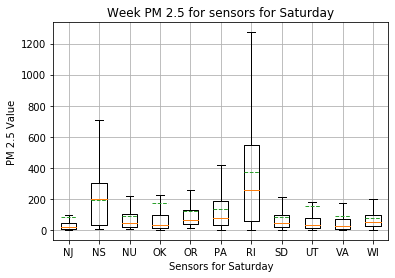

Sunday - NJ list size: 2880
Sunday - NS list size: 8793
Sunday - NU list size: 13564
Sunday - OK list size: 16735
Sunday - OR list size: 4087
Sunday - PA list size: 19124
Sunday - RI list size: 10077
Sunday - SD list size: 23543
Sunday - UT list size: 18298
Sunday - VA list size: 31541
Sunday - WI list size: 31840
Sunday total: 180482

whiskers:  [4.0, 109.0, 12.0, 688.0, 1.0, 251.0, 1.0, 155.0, 15.0, 558.0, 1.0, 474.0, 1.0, 1302.0, 0.0, 267.0, 1.0, 181.0, 0.0, 188.0, 2.0, 273.0]
caps:  [4.0, 109.0, 12.0, 688.0, 1.0, 251.0, 1.0, 155.0, 15.0, 558.0, 1.0, 474.0, 1.0, 1302.0, 0.0, 267.0, 1.0, 181.0, 0.0, 188.0, 2.0, 273.0]
boxes:  [12.0, 72.0, 19.0, 10.0, 72.0, 32.0, 52.0, 18.5, 14.0, 8.0, 26.0]
medians:  [20.0, 235.0, 51.0, 22.0, 132.0, 99.0, 176.0, 51.0, 32.0, 29.0, 63.0]
means:  [85.87361111111112, 244455.0856363016, 85.86545266882925, 108.91108455333134, 683.469292879863, 171.9227672035139, 365.6989183288677, 97.90132948222401, 120.1602360913761, 104.66725848895089, 90.89409547738694]

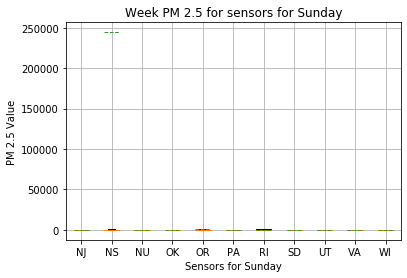

In [9]:
# Day each sensors - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html
import numpy as np
from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
unmodified_gers = ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])


# for name, sensor_data in data.groupby("name"):
for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = data[data.index.day_name() == day]
    # temp = temp.groupby("name")
    cumulative = 0
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].to_numpy().tolist())
        cumulative += len(sensor_data)
        print('{} - {} list size: {}'.format(day, name,  len(sensor_data)))
    print ('{} total: {}'.format(day, cumulative))    
    print()

    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()

data = gold_data